# Training Data

The training data is generated using real HSC images from the Ultra Deep (UD) field. The ground truth source detection masks are generated using the [scarlet](https://github.com/pmelchior/scarlet) deblender. HSC UD data can be accessed from https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/. We used the public DR2 UD stacks from: https://hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results. The HSC DR2 data is described in [Hiroaki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract).

Output function:
    
    for every band, output 1 fits file (name of input file, append _scarlet.fits at end)
    ... 3 fits files per 3 bands
    
    in each fits file:
        -have image itself (first header)
        - n headers for every n source detected in code
        - in every header will have an image of a model of that source and only that source
               this model will NOT be same size of full image. it'll be small cutout 
               thus for header of file imagename for those small cutouts need to put entry called bbox (4 vector) w/ X, Y, WIDTH, HEIGHT  ... tells you where cutout is in image
               
        - Set entry name (categoryID) to 1 for all (b/c all galaxies)
        
        
        From Fits files Colin can generate exact data structure for detectron.

In [4]:
import sys
# In case you need to point to pre-existing scarlet install
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [7]:
import sys, os
import numpy as np
import scarlet
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [8]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.2
1.1.1


In [152]:
def write_scarlet_results(datas, starlet_sources, model_frame, norm):
    ##############################
    # SAVE RESULTS!!!
    # Save full image
    save_hdu = fits.PrimaryHDU(data=img_rgb) # Primary HDU is full image
    header = save_hdu.header # each full image has a header with height, width of image
    header['HEIGHT'] = img_rgb.shape[0]
    header['WIDTH'] = img_rgb.shape[1]

    # Save each model source
    save_starlet_source_list = []

    for k, src in enumerate(len(starlet_sources)):

        # Get each model, make into image
        model = starlet_sources[k].get_model(frame=model_frame)
        model = observation.render(model)
        model = src.bbox.extract_from(model)
        
        img_rgb = scarlet.display.img_to_rgb(model, norm=norm)

        # Save model with location info (relative to full image file) in headers
        save_hdu_ss = fits.ImageHDU(data=starlet_source_img_rgb) #Ensure it's IMAGE HDU NOT PRIMARY
        save_hdr_ss = fits.Header()
        save_hdr_ss['CENTER_Y'] = starlet_sources[k].center[0]
        save_hdr_ss['CENTER_X'] = starlet_sources[k].center[1]
        save_hdr_ss['BBOX_STA'] = tuple(starlet_sources[k].bbox.start[1:3]) # ASK COLIN: CAN'T HAVE 3 tuple???
        save_hdr_ss['BBOX_STP'] = tuple(starlet_sources[k].bbox.stop[1:3])
        save_hdr_ss['ID'] = 1 # Category ID
        #print(tuple(starlet_sources[k].bbox.start[1:3]))
        #print(tuple(starlet_sources[k].bbox.stop[1:3]))
        save_starlet_source_list.append(save_hdu_ss)

    # Write final fits file to specified location
    #for channel in filters:
    #    save_hdul = fits.HDUList([save_hdu, save_starlet_source_list[0]])
    #    save_hdul.writeto(f'{dirpath}/HSC-{channel}/{tract}/{patch1},{patch2}/scarlet-HSC-{channel}-{tract}-{patch1},{patch2}_position={centerposY},{centerposX}_sizecut={sizecutY},{sizecutX}.fits') 

        

### Test Scarlet

First, let's test scarlet using one HSC UD image. The HSC image data is divided into "tracts" and "patches" on the sky. You can get the HSC image data given any ra, dec using the code below.

View HSC tract maps: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/

Tract, patch from coord: 9814 (6, 6)
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-G/9813/7,6/calexp-HSC-G-9813-7,6.fits.gz".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-R/9813/7,6/calexp-HSC-R-9813-7,6.fits.gz".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-I/9813/7,6/calexp-HSC-I-9813-7,6.fits.gz".
sigma_obs: 1.9984042359718097


/opt/apps/anaconda3/envs/wmlce-v1.7.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:198: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Source catalog found  193 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 38 iterations to logL = -732934.5581327518


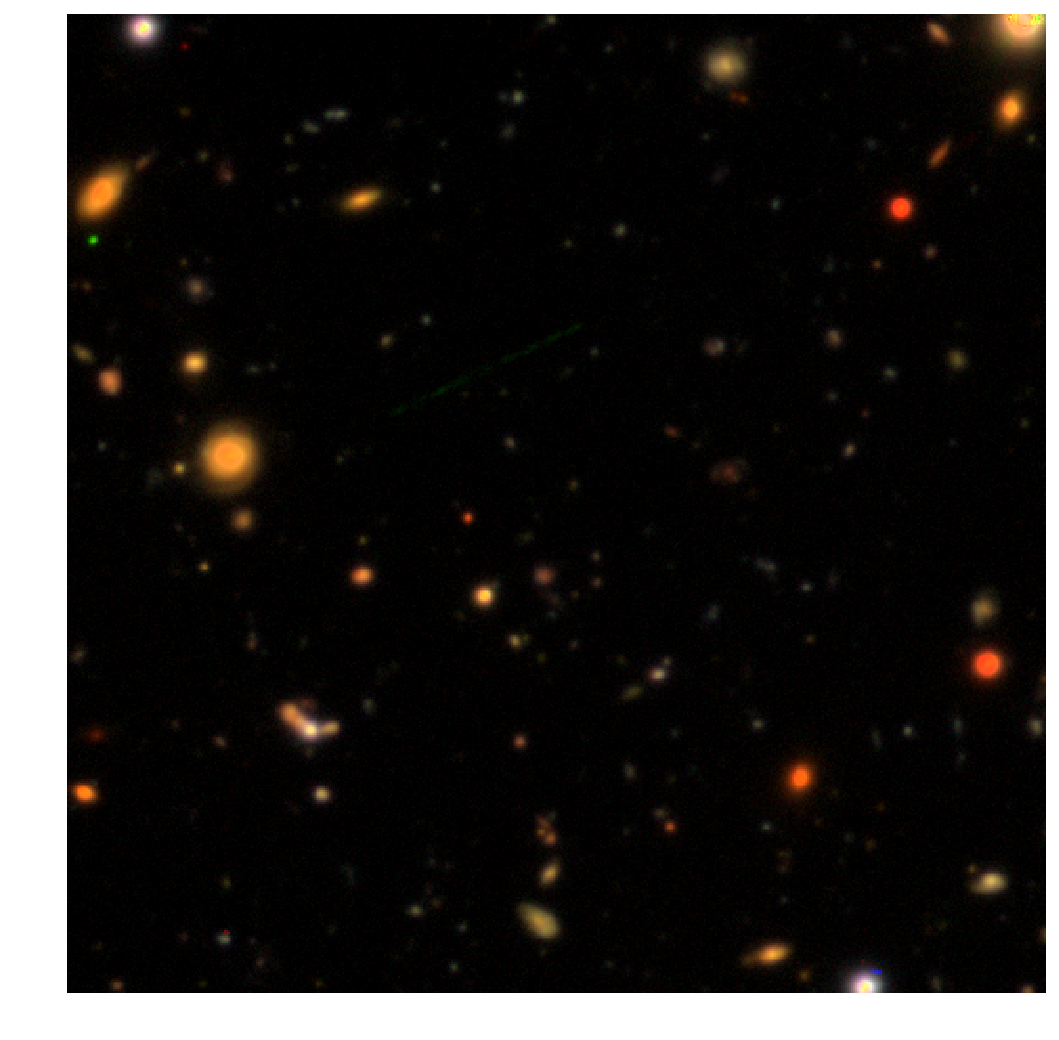

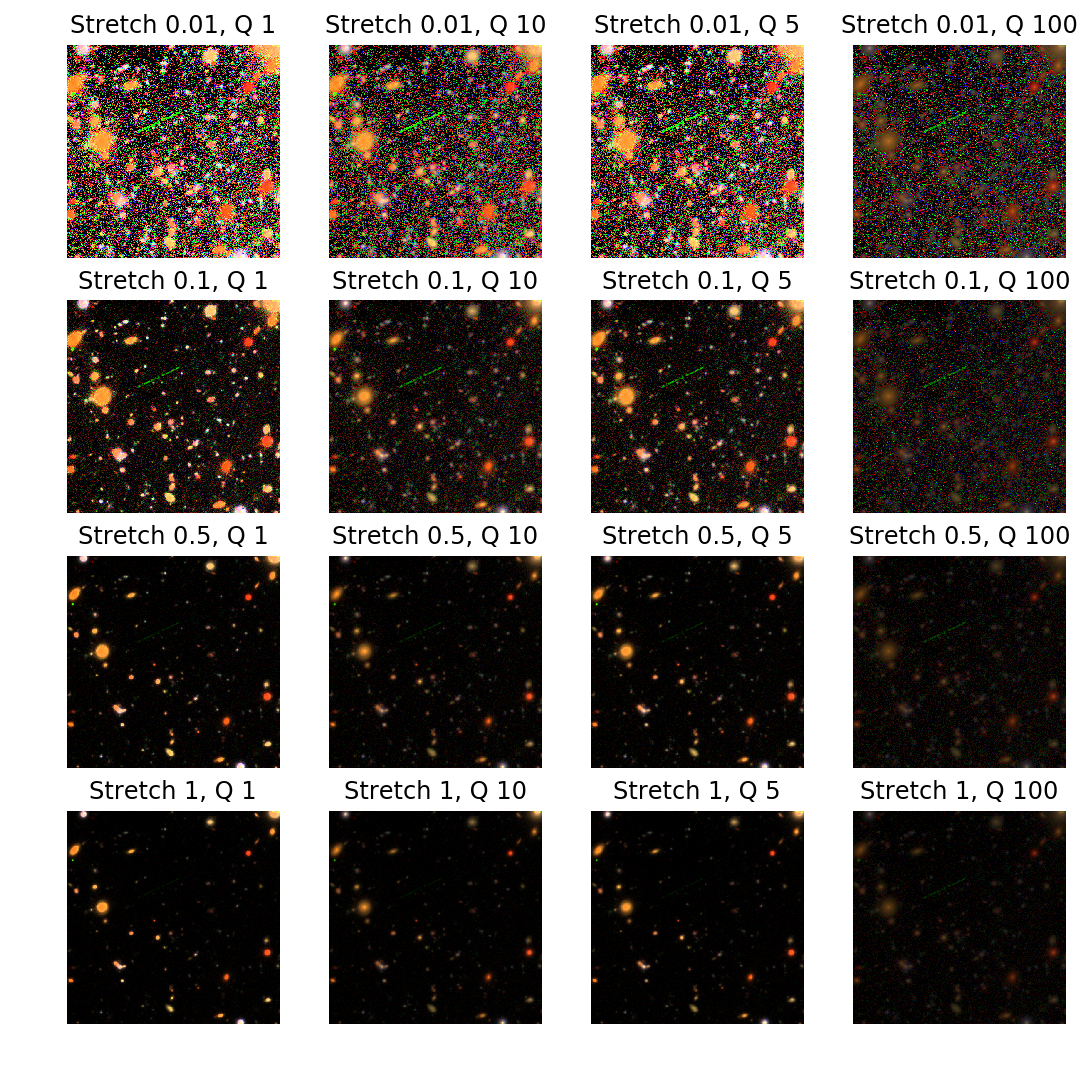

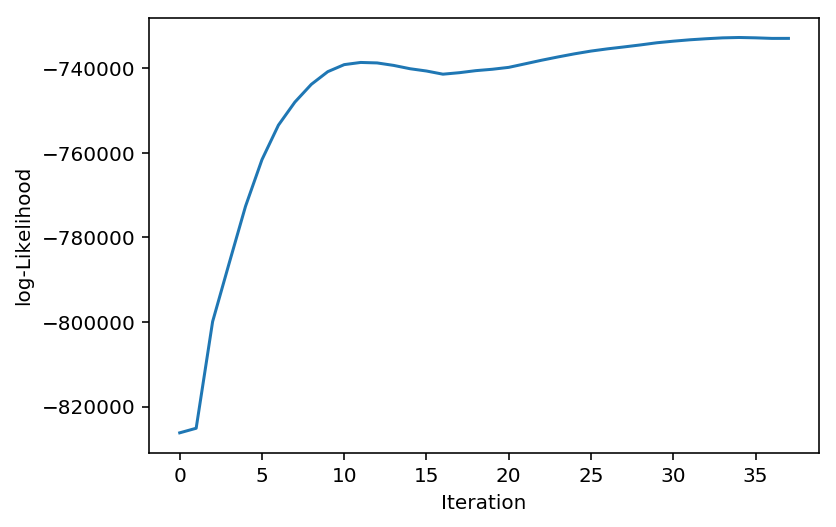

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 63 iterations to logL = -732467.4542683999


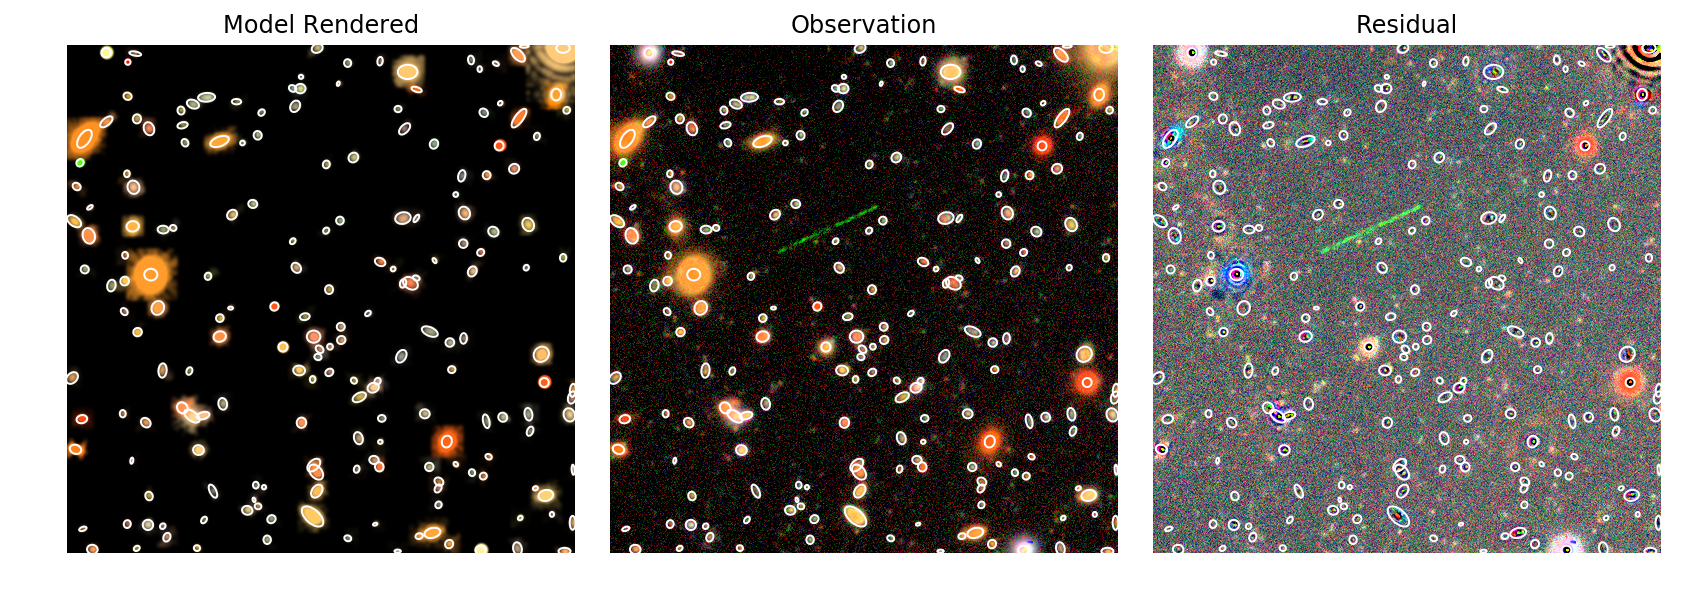

In [153]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data
from astrodet.scarlet import plot_stretch_Q, run_scarlet

filters = ['g', 'r', 'i']

# Input coordinate
c = SkyCoord(151.3818, 2.5851, unit='deg')

# Get the tract, patch
tract, patch = get_tract_patch_from_coord(c)
print('Tract, patch from coord:', tract, patch)

# Point to the HSC data directory
hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/'

# Get the HSC data from the file info
# Alternatively, you can add the coord argument directly into the arguments below
datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, tract=9813, patch=[7,6], plot_image=True, cutout_size=[512,512])

# Find good stretch and Q
plot_stretch_Q(datas)

# HSC Pixel scale in arcsec/pixel
ps = 0.17
# Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
print('sigma_obs:', sigma_obs)

# Run Scarlet
# START TIMING with plotting OFF
observation, scarlet_sources = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True, max_chi2=5000)
# END TIMING

# Save Scarlet data to FITS file
#write_scarlet_results(observation, scarlet_sources)

In [6]:
def generate_training_data(dirpath, bands=['g','r','i'], ratios=[1, 0.2, 0.2]):
    
    """
    Description.
    
    
    
    """
    
    import glob
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    b = bands[0]
    
    # /home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/**/**/**/calexp-HSC-G*.fits.gz
    files = glob.glob(os.path.join(dirpath, f'HSC-{b.upper()}/**/**/calexp-HSC-{b.upper()}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # TODO: This looses a couple files
    files_train = files[:i_train]
    files_val = files[i_train:i_train + i_val]
    files_test = files[-i_test:]
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Get tract, patch (use first band)
        for fi in f:

            s = fi.split(f'calexp-HSC-{b.upper()}-')[1].split('.fits.gz')[0]
            tract, patch = s.split('-')
            patch = tuple(map(int, patch.split(',')))
            
            # Get the HSC data from the file info
            #datas = get_hsc_data(dirpath=hsc_dirpath, bands=bands, tract=tract, patch=patch)
            
            # TODO: Split data up into chunks if you need to

            # Run Scarlet
            #observation, scarlet_sources = run_scarlet(datas, plot_scene=True)

            # Save Scarlet data to FITS file
            #write_scarlet_results(observation, scarlet_sources)
        
    return files_train, files_val, files_test

In [156]:
generate_training_data(hsc_dirpath)